In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, precision_recall_curve, matthews_corrcoef, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from catboost import Pool, cv
import optuna
from optuna.samplers import TPESampler
import logging
import sys
import umap.plot
import os
from tqdm import tqdm

In [2]:
#path='/content/drive/MyDrive/uai-sentencias-bias/archivosplaybooks_2/'
path= 'c:\\Users\\ea-ar10100\\Documents\\Tesis\\nuevo2\\'

In [3]:
#SENTENCES_FILE = './data/<YOUR_FILE_HERE>.csv'
#EMBEDDINGS_FILE = './data/<YOUR_EMBEDDINGS_HERE>.npy'
EMBEDDINGS_FILE = 'df_st.csv'
#EXPLANATIONS_FILE = './data/<YOUR_EXPLANATIONS_FILE_HERE>.pickle'
SENTENCES_FILE= 'sentences_with_annotations_20220323a.csv'
EXPLANATIONS_FILE = 'df_explicaciones.pickle'
#EMBEDDINGS_FILE='df_st.npy'
#SENTENCES_FILE = 'df_st.csv'
#EMBEDDINGS_FILE= '__anon__df_sentencetransformer-beto.pickle'
EMBEDDINGS_FILE= 'df_st.pickle'

In [9]:
# array(['tfidf', 'bertlegal4', 'multilingua4', 'beto4'], dtype=object)
def load_dataset(which, verbose=True):
    if which == 'beto4':
        filename = "..."
    elif which == 'bertlegal4':
        filename = "..."
    elif which == 'tfidf':
        filename = "..."
    elif which == 'multilingua4':
        sentences_df = pd.read_csv(SENTENCES_FILE)
        embeddings = np.load(EMBEDDINGS_FILE)
        if verbose:
            print(which, SENTENCES_FILE, sentences_df.shape)
            print(which, EMBEDDINGS_FILE, embeddings.shape)
        data_df = pd.DataFrame(embeddings)
        data_df['bias'] = sentences_df['bias']
        return data_df
    else:
        return None
    
    data_df = pd.read_csv(filename)
    data_df = data_df.drop(['doc','text','page'], axis=1)
    if verbose:
        print(which, filename, data_df.shape)
    return data_df

In [10]:
#from datasets import load_dataset
data_df = load_dataset('beto4')
#data_df = load_dataset('multilingua4')
data_df.head()

PermissionError: [Errno 13] Permission denied: '...'

In [ ]:
# Ratio between positive and negative examples
scale_pos_weight = len(data_df[data_df.bias==0]) / len(data_df[data_df.bias==1])
print(scale_pos_weight)
data_df['bias'].value_counts()

25.682926829268293


bias
0    1053
1      41
Name: count, dtype: int64

In [ ]:
def train_catboost(df, test_size=0.2, random_seed=4, plot=False, weight=1, metric='MCC', learning_rate=0.034741, verbose=True, extra_results=False):
     if verbose:
          print(metric)
     X = df.drop('bias', axis=1)
     y = df['bias']

     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_seed)
     if verbose:
          model = CatBoostClassifier(loss_function='Logloss', eval_metric=metric, learning_rate=learning_rate,
                              scale_pos_weight=weight, random_seed=random_seed, verbose=verbose)
     else:
          model = CatBoostClassifier(loss_function='Logloss', eval_metric=metric, learning_rate=learning_rate,
                              scale_pos_weight=weight, random_seed=random_seed, logging_level='Silent')
     # XXXX
     model.fit(X_train, y_train, eval_set=(X_test, y_test),
               verbose_eval=300,
               early_stopping_rounds=500,
               use_best_model=True,
               plot=plot)

     class_predictions = model.predict(X_test)
     probability_predictions = model.predict_proba(X_test)

     if verbose:
          log_loss_value = log_loss(y_test, probability_predictions[:,1])
          print(f'Log Loss: {log_loss_value}')

          roc_auc = roc_auc_score(y_test, probability_predictions[:,1])
          print(f'ROC AUC: {roc_auc}')

          mcc = matthews_corrcoef(y_test, class_predictions)
          print(f'MCC: {mcc}')

     class_report = classification_report(y_test, class_predictions)
     if verbose:
          print(f'Classification Report:\n {class_report}')

     if plot:
          # ConfusionMatrixDisplay.from_predictions(y_test, class_predictions)
          ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
          plt.show()

     if extra_results:
          return model, X_test, y_test, classification_report(y_test, class_predictions, output_dict=True)
     else:
          return model

In [ ]:
def crosseval_catboost(df, kfold=5, random_seed=4, plot=False, weight=1, metric='MCC', learning_rate=0.034741):
    print(metric)
    X = df.drop('bias', axis=1)
    y = df['bias']

    params = {"iterations": 500,
          "learning_rate": learning_rate,
          "random_seed": random_seed,
          #"depth": 2,
          "loss_function": "Logloss",
          "eval_metric": metric,
          "scale_pos_weight": weight,
          "logging_level": 'Silent'
          #"verbose": False
    }

    scores = cv(
        params = params,
        pool = Pool(data=X,label=y),
        fold_count=kfold,
        shuffle=True,
        #partition_random_seed=0,
        plot=plot,
        stratified=True,
        verbose=False
    )

    best_value_logloss = scores['test-Logloss-mean'].min()
    best_iter_logloss = scores['test-Logloss-mean'].values.argmin()
    std_logloss = scores['test-Logloss-std'].values[best_iter_logloss]
    best_value_metric = scores['test-'+metric+'-mean'].max()
    best_iter_metric = scores['test-'+metric+'-mean'].values.argmax()
    std_metric = scores['test-'+metric+'-std'].values[best_iter_metric]

    print(f'Best Log Loss: {best_value_logloss} at iteration {best_iter_logloss}, std: {std_logloss}')
    print(f'Best {metric}: {best_value_metric} at iteration {best_iter_metric}, std: {std_metric}')

    return scores

In [ ]:
def objective(trial, df, metric, kfolds=5, iterations=500, depth=2):
    params = {
        "iterations": iterations,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "random_seed": trial.suggest_int("random_seed", 1, 10),
        "depth": depth,
        "loss_function": "Logloss",
        "eval_metric": metric, #"Recall", # "MCC",
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 25, step=0.5),
        "logging_level": 'Silent'
    }

    X = df.drop('bias', axis=1)
    y = df['bias']
    scores_df = cv(
        params=params,
        pool=Pool(data=X,label=y),
        fold_count=kfolds,
        shuffle=True,
        plot=False,
        stratified=True,
        verbose=False
    )

    best_value_logloss = scores_df['test-Logloss-mean'].min()
    best_value_metric = scores_df['test-'+metric+'-mean'].max()

    rs = params['random_seed']
    lr = params['learning_rate']
    w = params['scale_pos_weight']
    best_model, X_test, y_test, class_report = train_catboost(df, weight=w, plot=False, random_seed=rs, metric=metric, learning_rate=lr,
                                                    extra_results=True, verbose=False)

    trial.set_user_attr('1-precision', class_report['1']['precision'])
    trial.set_user_attr('1-recall', class_report['1']['recall'])
    trial.set_user_attr('metric', metric)

    return best_value_metric


def run_optuna(df, study_id, database_name="example-study.db", n_trials=10, metric='MCC'):
    print('Optimizing for', metric)
    study_name = database_name.replace(".db", str(study_id)) # Unique identifier for each study.
    storage_name = "sqlite:///{}".format(database_name)
    print("DB:", storage_name, study_name)

    # Run the study
    sampler = TPESampler(seed=1)
    study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True, sampler=sampler)
    obj = lambda trial: objective(trial, df, metric)
    study.optimize(obj, n_trials=n_trials, show_progress_bar=True)

    print('Best hyperparameters:', study.best_params)
    print('Best '+metric+':', study.best_value)
    return study


In [ ]:
# Run hyper-parameter tuning, if necessary
#study = run_optuna(data_df, study_id=1, n_trials=8, metric='MCC')

Optimizing for MCC
DB: sqlite:///example-study.db example-study1


[I 2024-06-17 11:39:53,650] A new study created in RDB with name: example-study1


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: Unde

[I 2024-06-17 11:42:26,540] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.006824078427098834, 'random_seed': 8, 'scale_pos_weight': 1.0}. Best is trial 0 with value: 0.0.


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: Unde

[I 2024-06-17 11:46:18,012] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.00402406646471461, 'random_seed': 2, 'scale_pos_weight': 3.0}. Best is trial 0 with value: 0.0.
[I 2024-06-17 11:50:01,197] Trial 2 finished with value: 0.06955039765177672 and parameters: {'learning_rate': 0.002357873072646738, 'random_seed': 4, 'scale_pos_weight': 10.5}. Best is trial 2 with value: 0.06955039765177672.
[I 2024-06-17 11:53:41,324] Trial 3 finished with value: 0.31139780278100604 and parameters: {'learning_rate': 0.011957309429716375, 'random_seed': 5, 'scale_pos_weight': 17.5}. Best is trial 3 with value: 0.31139780278100604.


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: Unde

[I 2024-06-17 11:57:25,724] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 0.002563920173316311, 'random_seed': 9, 'scale_pos_weight': 1.5}. Best is trial 3 with value: 0.31139780278100604.
[I 2024-06-17 12:01:16,551] Trial 5 finished with value: 0.4171981366287404 and parameters: {'learning_rate': 0.021924768698806385, 'random_seed': 5, 'scale_pos_weight': 14.5}. Best is trial 5 with value: 0.4171981366287404.
[I 2024-06-17 12:04:52,475] Trial 6 finished with value: 0.26839549435481364 and parameters: {'learning_rate': 0.0019088591198098556, 'random_seed': 2, 'scale_pos_weight': 20.5}. Best is trial 5 with value: 0.4171981366287404.
[I 2024-06-17 12:08:25,010] Trial 7 finished with value: 0.30438404401694347 and parameters: {'learning_rate': 0.08640187187029895, 'random_seed': 4, 'scale_pos_weight': 17.5}. Best is trial 5 with value: 0.4171981366287404.
Best hyperparameters: {'learning_rate': 0.021924768698806385, 'random_seed': 5, 'scale_pos_weight': 14.5}
Best MC

In [ ]:
data_df.head()

,bias,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,0,-0.103298,0.058581,-0.245644,0.568279,-0.460503,-0.260826,-0.138290,-0.062721,0.443447,...,0.022160,0.189041,-0.158408,0.975289,0.225788,-0.046370,-0.597890,0.082916,0.212562,0.866128
1,0,0.297816,-0.036549,-0.307048,0.457950,0.011579,-0.026042,-0.037664,-0.405174,0.524132,...,-0.266126,0.019075,-0.104618,0.964871,0.084014,-0.541404,-0.600119,-0.020455,0.272396,0.123006
2,0,-0.392469,0.526240,0.106453,-0.224158,-0.071554,-0.476213,0.014736,-0.820843,0.893263,...,-0.244686,-0.189997,-0.152274,0.370419,0.281939,-0.245589,-0.950262,-0.247998,0.362437,0.311452
3,0,-0.938112,0.335014,-0.266935,0.155191,-0.487459,-0.606632,0.052949,-0.291127,0.371549,...,0.176949,0.164829,0.095965,0.238389,-0.522928,-0.007793,-0.455212,-0.382197,1.067601,0.534942
4,0,-0.434473,-0.025824,0.102531,0.195162,-0.373819,-0.798969,0.093257,0.159641,0.267056,...,0.359802,0.213900,-0.039211,0.500330,0.656412,0.196934,-0.047523,-0.144383,0.951350,0.987135


MCC


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5504283	test: 0.2572631	best: 0.2572631 (0)	total: 577ms	remaining: 9m 36s
300:	learn: 0.9904475	test: -0.0965176	best: 0.3818536 (10)	total: 1m 12s	remaining: 2m 48s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3818535724
bestIteration = 10

Shrink model to first 11 iterations.
Log Loss: 0.6729559074718913
ROC AUC: 0.8329383886255926
MCC: 0.22592351722151532
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       211
           1       0.19      0.38      0.25         8

    accuracy                           0.92       219
   macro avg       0.58      0.66      0.60       219
weighted avg       0.95      0.92      0.93       219



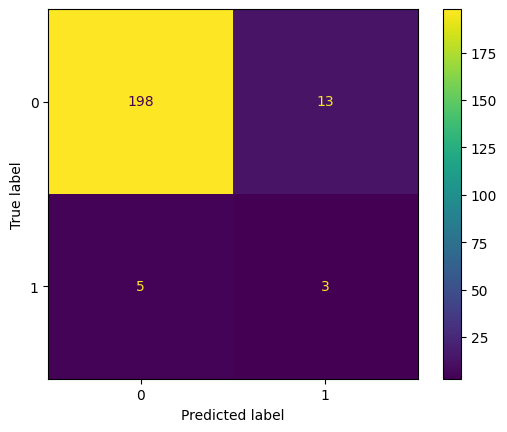

In [ ]:
# print(trial.best_params, trial.best_value)

rs = 6 #trial.best_params['random_seed']
w = 25 #trial.best_params['scale_pos_weight']
lr = 0.002574 #trial.best_params['learning_rate']

best_model, X_test, y_test, class_report = train_catboost(data_df, weight=w, plot=True, random_seed=rs, metric='MCC', learning_rate=lr, extra_results=True)


In [ ]:
pd.DataFrame(class_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.975369,0.1875,0.917808,0.581435,0.946589
recall,0.938389,0.3750,0.917808,0.656694,0.917808
f1-score,0.956522,0.2500,0.917808,0.603261,0.930713
support,211.000000,8.0000,0.917808,219.000000,219.000000


In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

umap_args2 = {'n_neighbors': 15,
             'n_components': 2,
             'metric': 'cosine'}

embeddings = data_df.drop('bias', axis=1).values
print(embeddings.shape)

umap_model2D = umap.UMAP(**umap_args2, random_state=42).fit(embeddings)
u = umap_model2D.transform(embeddings)
# crosseval_catboost(data_df, weight=w, plot=True, random_seed=rs, metric='PRAUC')

(1094, 768)


c:\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
def plot_bias(u, y, title=""):
    c = ['gray' if x == 0 else 'r' for x in y]
    plt.scatter(u[:,0], u[:,1], c=c, alpha=0.4, s=12)
    plt.axis("off")
    plt.title(title)
    plt.show()

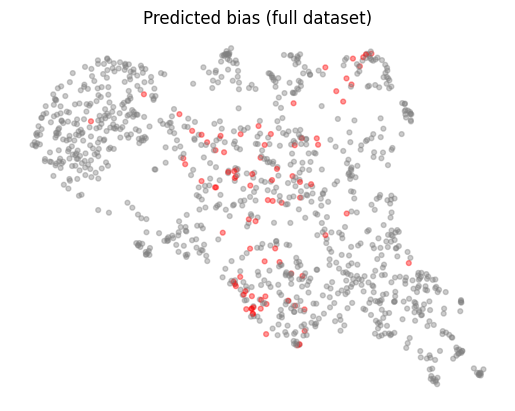

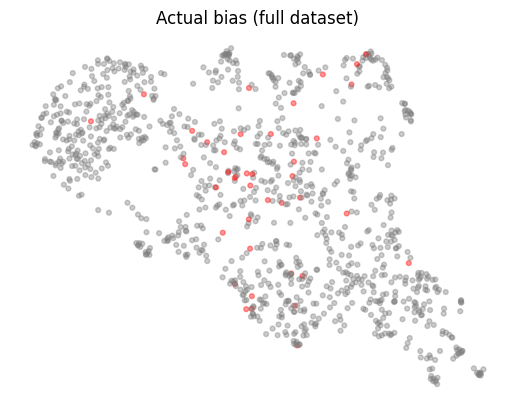

In [ ]:
y = best_model.predict(embeddings)
plot_bias(u, y, title='Predicted bias (full dataset)')

y = data_df['bias']
plot_bias(u, y, title='Actual bias (full dataset)')

c:\Python312\Lib\site-packages\umap\plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

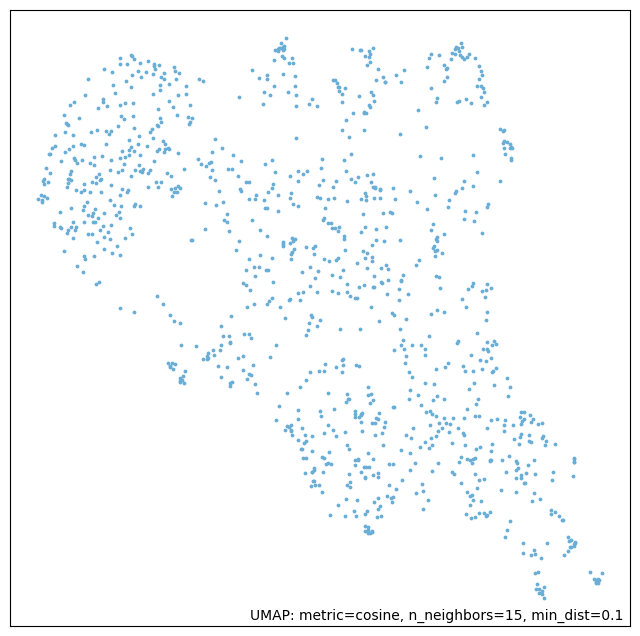

In [ ]:
import umap.plot

umap.plot.points(umap_model2D)